<h1 style = "color : Brown"> Real Vs Fake Job Posting </h1>

##### Problem Statement:
- The project includes visualizing the data and building a model to predict if any job posting is real or fake given the details about the posting.

##### Motivation of choosing the dataset:
- As nowadays many fraudulent companies post fake jobs to collect candidates’ personal data and try to misuse it. It would be a helpful tool if the candidate can make sure if any given posting is genuine or not.

##### Data:
- Data was given by the University of the Aegean | Laboratory of Information & Communication Systems Security downloaded from Kaggle

##### Resources :
- https://www.kaggle.com/datasets/shivamb/real-or-fake-fake-jobposting-prediction?resource=download
- https://mkzia.github.io/eas503-notes/sql.html

##### Data Description:
The dataset consists of 17,880 observations and 18 features. The data is a combination of integer, binary and textual datatypes. A brief definition of the attributes is given below:


- Job_ID - Unique ID for each job
- Title – Description of the job position.
- Location - Geographical location of the job
- Department – Information about the department of the offered job(Sales, maketing etc)
- Salary Range - Salary range for the job
- Company profile - A brief description of the company.
- Description - Detail description of job ad
- Requirements - Pre-requisites to qualify for the job
- Benefits – Enlisted benefits provided by the job 
- Telecommuting - work from home or remote work allowed or not in the job.
- Has company logo - Does the job posting have a company logo
- Has questions - Does the job posting have screening questions
- Employment Type - Full-time, Part-time, Contract, etc.
- Required experience – It can be Executive, Entry level, Intern, etc.
- Required education – It can be Doctorate, Master’s Degree, Bachelor, etc.
- Industry - The industry the job posting is relevant to (Automotive, IT, Health care etc.)
- Function – Information about the Job’s functionality (Consulting, Engineering, Research, Sales etc.)
- Fradulent - If the job posting is fake or not

## Importing necessary libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import sqlite3
from sqlite3 import Error
import csv
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import nltk
from nltk.corpus import gutenberg, stopwords
from nltk.collocations import *
from nltk import word_tokenize
import string
import re
from wordcloud import WordCloud, STOPWORDS

## Defining functions for Sqlite

In [2]:
def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn


def create_table(conn, create_table_sql, drop_table_name=None):
    
    if drop_table_name: # You can optionally pass drop_table_name to drop the table. 
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)
    
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows

In [3]:
# Initializing Filename
filename = "fake_job_postings.csv"

#### Reading the csv file and storing it in a list of tuples

In [4]:
with open(filename) as file:
    raw_data = list(csv.reader(file, delimiter=","))
raw_data = raw_data[1:]
raw_data1 = [tuple(i) for i in raw_data]

#### Creating a raw data table in raw_data.db database and inserting the raw data into it before normalizing

In [5]:
db_file = 'raw_data.db'
import os
if os.path.exists(db_file):
    os.remove(db_file)
conn = create_connection(db_file)

create_table_sql1 = """
    CREATE TABLE IF NOT EXISTS [raw_data] (
        [job_id] integer not null primary key,
        [title] text,
        [location] text,
        [department] text,
        [salary_range] text,
        [company_profile] text,
        [description] text,
        [requirements] text,
        [benefits] text,
        [telecommuting] integer,
        [has_company_logo] integer,
        [has_questions] integer,
        [employment_type] text,
        [required_experience] text,
        [required_education] text,
        [industry] text,
        [function] text,
        [fraudulent] integer
    );
    """

def insert_raw_data(conn, values):
    sql = ''' INSERT INTO raw_data(job_id,title,location,
                department,salary_range,company_profile,description,
                requirements,benefits,telecommuting,has_company_logo,
                has_questions,employment_type,required_experience,
                required_education,industry,function,fraudulent) 
                VALUES(?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?) '''
    cur = conn.cursor()
    cur.execute(sql, values)
    return cur.lastrowid

with conn:
        create_table(conn, create_table_sql1)
        for values in raw_data1:
            insert_raw_data(conn,values)

## Normalization of Data

#### Creating a connection to a database to create normalized tables

In [6]:
db_file_norm = 'normalized_data.db'
if os.path.exists(db_file_norm):
    os.remove(db_file_norm)
conn1 = create_connection(db_file_norm)

#### Normalizing the data

###### Creating titles, departments, salaries, requirements, benefits table

In [7]:
with conn:
    sql_statement = 'SELECT distinct job_id,title,location,department,salary_range,company_profile,description,requirements,benefits from raw_data'
    raw_data = execute_sql_statement(sql_statement, conn)

In [8]:
job_idx = []
titles = []
depts = []
salaries = []
requirements = []
benefits = []

for data in raw_data:
    job_id = data[0]
    job_idx.append(job_id)
    
    title = data[1]
    titles.append((title,))
    
    dept = data[3]
    depts.append((dept,))
    
    salary_range = data[4]
    if '-' in salary_range:
        min_salary = salary_range.split('-')[0].split(' ')[0]
        max_salary = salary_range.split('-')[1].split(' ')[-1]
    else:
        min_salary = ''
        max_salary = ''
    salaries.append((salary_range, min_salary, max_salary))
    
    requirement = data[7]
    requirements.append((requirement,))
    
    benefit = data[8]
    benefits.append((benefit,))

titles = tuple(set(titles))
depts = tuple(set(depts))
salaries = tuple(set(salaries))
requirements = tuple(set(requirements))
benefits = tuple(set(benefits))

In [9]:
def insert_titles(titles,conn):
    table_sql = """
                    CREATE TABLE [Titles] (
                        [TitleID] Integer not null primary key,
                        [Title] Text
                    )
                    """
    
    cur = conn.cursor()
    insert_sql = """
                    INSERT INTO Titles (Title)
                    Values (?)
                    """
    
    with conn:
        create_table(conn, table_sql, "Titles")
        cur.executemany(insert_sql, titles)
    return cur.lastrowid
    
def insert_departments(departments,conn):
    table_sql = """
                    CREATE TABLE [Departments] (
                        [DepartmentID] Integer not null primary key,
                        [Department] Text
                    )
                    """
    
    cur = conn.cursor()
    insert_sql = """
                    INSERT INTO Departments (Department)
                    Values (?)
                    """
    with conn:
        create_table(conn, table_sql, "Departments")
        cur.executemany(insert_sql, departments)
    return cur.lastrowid
    
def insert_salaries(salaries,conn):
    table_sql = """
                    CREATE TABLE [Salaries] (
                        [SalaryID] Integer not null primary key,
                        [Salary_Range] Text,
                        [Min_Salary] REAL,
                        [Max_Salary] REAL
                    );
                    """
    
    cur = conn.cursor()
    insert_sql = """
                    INSERT INTO Salaries (Salary_Range, Min_Salary, Max_Salary)
                    Values (?,?,?)
                    """
    with conn:
        create_table(conn, table_sql, "Salaries")
        cur.executemany(insert_sql, salaries)
    return cur.lastrowid
    
def insert_requirements(requirements,conn):
    table_sql = """
                    CREATE TABLE [Requirements] (
                        [RequirementID] Integer not null primary key,
                        [Requirement] Text
                    )
                    """
    
    cur = conn.cursor()
    insert_sql = """
                    INSERT INTO Requirements (Requirement)
                    Values (?)
                    """
    with conn:
        create_table(conn, table_sql, "Requirements")
        cur.executemany(insert_sql, requirements)
    return cur.lastrowid
    
def insert_benefits(benefits,conn):
    table_sql = """
                    CREATE TABLE [Benefits] (
                        [BenefitID] Integer not null primary key,
                        [Benefit] Text
                    )
                    """
    
    cur = conn.cursor()
    insert_sql = """
                    INSERT INTO Benefits (Benefit)
                    Values (?)
                    """
    with conn:
        create_table(conn, table_sql, "Benefits")
        cur.executemany(insert_sql, benefits)
    return cur.lastrowid
    
insert_titles(titles,conn1)
insert_departments(depts,conn1)
insert_salaries(salaries,conn1)
insert_requirements(requirements,conn1)
insert_benefits(benefits,conn1)

###### Creating telecommuting table

In [10]:
with conn:
    sql_statement = 'SELECT distinct telecommuting from raw_data'
    value_telecommuting = execute_sql_statement(sql_statement, conn)
    
    
create_table_telecommuting = """
    CREATE TABLE IF NOT EXISTS [Telecommuting] (
        [telecommutingId] integer not null primary key,
        [isTelecommuting] integer not null
    );
    """

def insert_telecommuting(conn, values):
    sql = ''' INSERT INTO Telecommuting(isTelecommuting) 
                VALUES(?) '''
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid

   

with conn1:
    create_table(conn1, create_table_telecommuting,'Telecommuting')
    insert_telecommuting(conn1,value_telecommuting)

###### Creating Company logo table

In [11]:
with conn:
    sql_statement = 'SELECT distinct has_company_logo from raw_data'
    value_companylogo = execute_sql_statement(sql_statement, conn)
    
    
create_table_sql2 = """
    CREATE TABLE IF NOT EXISTS [Companylogo] (
        [LogoId] integer not null primary key,
        [HasLogo] integer not null
    );
    """

def insert_companylogo(conn, values):
    sql = ''' INSERT INTO Companylogo(HasLogo) 
                VALUES(?) '''
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid

   

with conn1:
    create_table(conn1, create_table_sql2,'Companylogo')
    insert_companylogo(conn1,value_companylogo)

###### Creating HasQuestions table

In [12]:
with conn:
    sql_statement = 'SELECT distinct has_questions from raw_data'
    value_questions = execute_sql_statement(sql_statement, conn)
    
create_table_sql2 = """
    CREATE TABLE IF NOT EXISTS [HasQuestions] (
        [QuestionId] integer not null primary key,
        [HasQuestion] integer not null
    );
    """

def insert_questions(conn, values):
    sql = ''' INSERT INTO HasQuestions(HasQuestion) 
                VALUES(?) '''
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid

   

with conn1:
    create_table(conn1, create_table_sql2,'HasQuestions')
    insert_questions(conn1,value_questions)

###### Creating Employment type table

In [13]:
with conn:
    sql_statement = 'SELECT distinct employment_type from raw_data'
    value_employment_type = execute_sql_statement(sql_statement, conn)

create_table_sql2 = """
    CREATE TABLE IF NOT EXISTS [EmploymentTypes] (
        [EmploymentTypeId] integer not null primary key,
        [EmploymentType] text
    );
    """

def insert_eType(conn, values):
    sql = ''' INSERT INTO EmploymentTypes(EmploymentType) 
                VALUES(?) '''
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid

   

with conn1:
    create_table(conn1, create_table_sql2,'EmploymentTypes')
    insert_eType(conn1,value_employment_type)

###### Creating required experience table

In [14]:
with conn:
    sql_statement = 'SELECT distinct required_experience from raw_data'
    value_required_experience = execute_sql_statement(sql_statement, conn)

    
create_table_sql2 = """
    CREATE TABLE IF NOT EXISTS [RequiredExperiences] (
        [RequiredExperienceId] integer not null primary key,
        [RequiredExperience] Text
    );
    """

def insert_req_experience(conn, values):
    sql = ''' INSERT INTO RequiredExperiences(RequiredExperience) 
                VALUES(?) '''
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid

   

with conn1:
    create_table(conn1, create_table_sql2,'RequiredExperience')
    insert_req_experience(conn1,value_required_experience)

###### Creating required education table

In [15]:
with conn:
    sql_statement = 'SELECT distinct required_education from raw_data'
    value_required_education = execute_sql_statement(sql_statement, conn) 
    
create_table_sql2 = """
    CREATE TABLE IF NOT EXISTS [RequiredEducation] (
        [RequiredEducationId] integer not null primary key,
        [Education] Text
    );
    """

def insert_req_education(conn, values):
    sql = ''' INSERT INTO RequiredEducation(Education) 
                VALUES(?) '''
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid

   

with conn1:
    create_table(conn1, create_table_sql2,'Education')
    insert_req_education(conn1,value_required_education)

###### Creating Industry table

In [16]:
with conn:
    sql_statement = 'SELECT distinct industry from raw_data'
    value_industry = execute_sql_statement(sql_statement, conn) 
    
create_table_sql2 = """
    CREATE TABLE IF NOT EXISTS [Industry] (
        [IndustryId] integer not null primary key,
        [IndustryName] Text
    );
    """

def insert_Industry(conn, values):
    sql = ''' INSERT INTO Industry(IndustryName) 
                VALUES(?) '''
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid

   

with conn1:
    create_table(conn1, create_table_sql2,'Industry')
    insert_Industry(conn1,value_industry)

###### Creating function table

In [17]:
with conn: 
    sql_statement = "SELECT distinct function from raw_data"
    value_profile = execute_sql_statement(sql_statement, conn)

create_table_sql2 = """
    CREATE TABLE IF NOT EXISTS [function] (
        [functionID] integer not null primary key,
        [function] text not null
    );
    """

def insert_profile(conn, values):
    sql = ''' INSERT INTO function(function) 
                VALUES(?) '''
    cur = conn.cursor()
    cur.execute(sql, values)
    return cur.lastrowid

   

with conn1:
    create_table(conn1, create_table_sql2,'function')
    for values in value_profile:
        insert_profile(conn1,values)

###### Creating fraudulent table

In [18]:
with conn: 
    sql_statement = "SELECT distinct fraudulent from raw_data where fraudulent != ''"
    value_fraudulent = execute_sql_statement(sql_statement, conn)

create_table_sql2 = """
    CREATE TABLE IF NOT EXISTS [fraudulent] (
        [fraudulent] integer not null primary key
    );
    """

def insert_profile(conn, values):
    sql = ''' INSERT INTO fraudulent(fraudulent) 
                VALUES(?) '''
    cur = conn.cursor()
    cur.execute(sql, values)
    return cur.lastrowid

   

with conn1:
    create_table(conn1, create_table_sql2,'fraudulent')
    for values in value_fraudulent:
        insert_profile(conn1,values)

###### Creating telecommuting table

In [19]:

with conn: 
    sql_statement = "SELECT distinct description from raw_data"
    value_profile = execute_sql_statement(sql_statement, conn)

create_table_sql2 = """
    CREATE TABLE IF NOT EXISTS [Description] (
        [DescriptionID] integer not null primary key,
        [Description] text not null
    );
    """

def insert_profile(conn, values):
    sql = ''' INSERT INTO Description(Description) 
                VALUES(?) '''
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid

   

with conn1:
    create_table(conn1, create_table_sql2,'Description')
    insert_profile(conn1,value_profile)

##### Creating Company table

In [20]:
sql_statement = 'SELECT distinct company_profile, has_company_logo,count(job_id) from raw_data group by company_profile,has_company_logo order by company_profile'
df = pd.read_sql_query(sql_statement, conn)
display(df)

,company_profile,has_company_logo,count(job_id)
0,,0,2622
1,,1,686
2,Value Added Team of Creative ProfessionalsNet...,1,1
3,"""Only stupid questions create wealth"" - Gary ...",1,1
4,"""Our mission to our clients is to preserve the...",1,64
...,...,...,...
1706,Το #URL_bb79581a561837ad604b8fc4ab629753b36407...,1,4
1707,"УУРРАА - технологическая компания, работающая ...",1,9
1708,“News360 is Changing the Content Delivery Game...,1,1
1709,"“No surveys, social data can answer your quest...",1,1


In [21]:
l1 = df.iloc[2:,0].values
l1.shape

(1709,)

In [22]:
np.unique(l1).shape

(1709,)

In [23]:
sql_statement = 'SELECT distinct department, count(job_id) from raw_data group by department'
df = pd.read_sql_query(sql_statement, conn)
df.head(50)

,department,count(job_id)
0,,11547
1,,6
2,\tCorporate Shared Services,1
3,Lower Level Management,1
4,Marketing,1
5,Moni Technologies,1
6,R&D,1
7,(Consultant),1
8,.NET,1
9,.net Development,1


###### Combination of company profile and has logo are distinct together hence we have merged them in the same table

In [24]:
with conn: 
    sql_statement = "SELECT distinct company_profile,description,has_company_logo from raw_data"
    value_profile = execute_sql_statement(sql_statement, conn)
with conn1: 
    sql_statement = "SELECT DescriptionID,Description from Description"
    value_comp = execute_sql_statement(sql_statement, conn1)
comp_dict = {}
desc_list = []

for row in value_comp:
    key,text = row
    comp_dict[text] = key

for i in value_profile:
    for k1,v1 in comp_dict.items():
        if i[1] == k1:
            desc_list.append((i[0],i[2],v1))

create_table_sql2 = """
    CREATE TABLE IF NOT EXISTS [Company] (
        [CompanyID] integer not null primary key,
        [company_profile] text,
        [has_company_logo] integer,
        [DescriptionID] integer not null,
        Foreign key(DescriptionID) references Description(DescriptionID)
    );
    """

def insert_profile(conn, values):
    sql = ''' INSERT INTO Company(company_profile,has_company_logo,DescriptionID) 
                VALUES(?,?,?) '''
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid

   

with conn1:
    create_table(conn1, create_table_sql2,'Company')
    insert_profile(conn1,desc_list)

###### Creating Location table by splitting the location column into country, state and city

In [25]:
with conn: 
    sql_statement = "SELECT distinct location from raw_data"
    value_profile = execute_sql_statement(sql_statement, conn)
    
list_country = []
list_state = []
list_city = []
list_loc1 = []
for i in value_profile:
    for j in i:
        list_loc1.append(j)
        if j.split(',')[0].strip() != '':
            list_country.append(j.split(',')[0].strip())
        else:
            list_country.append('')
        if len(j.split(','))!=1:
            if j.split(',')[1].strip() != '':
                list_state.append(j.split(',')[1].strip())
            else:
                list_state.append('')
        else:
            list_state.append('')
        if len(j.split(','))!=1:
            if j.split(',')[2].strip() != '':
                list_city.append(j.split(',')[2].strip())
            else:
                list_city.append('')
        else:
            list_city.append('')

list_loc = [(i,j,k,l) for i,j,k,l in zip(list_loc1,list_country,list_state,list_city)]

create_table_sql2 = """
    CREATE TABLE IF NOT EXISTS [Location] (
        [LocationID] integer not null primary key,
        [Location] text not null,
        [Country] text not null,
        [State] text not null,
        [City] text not null
    );
    """

def insert_profile(conn, values):
    sql = ''' INSERT INTO Location(Location,Country,State,City) 
                VALUES(?,?,?,?) '''
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid

   

with conn1:
    create_table(conn1, create_table_sql2,'Location')
    insert_profile(conn1,list_loc)

###### Creating Posting table which can be used to join the other tables with each other

In [26]:
with conn: 
    sql_statement = """SELECT distinct job_id,title,location,department,salary_range,
    company_profile,requirements,benefits,telecommuting, has_questions,
    employment_type,required_experience,required_education,industry,
    function,fraudulent from raw_data"""
    raw_data_post = execute_sql_statement(sql_statement, conn)
with conn1: 
    sql_statement1 = "SELECT TitleID,Title from Titles"
    value_title = execute_sql_statement(sql_statement1, conn1)
    sql_statement2 = "SELECT LocationID,Location from Location"
    value_loc = execute_sql_statement(sql_statement2, conn1)
    sql_statement3 = "SELECT DepartmentID,Department from Departments"
    value_dept = execute_sql_statement(sql_statement3, conn1)
    sql_statement4 = "SELECT SalaryID,Salary_Range from Salaries"
    value_sal = execute_sql_statement(sql_statement4, conn1)
    sql_statement5 = "SELECT CompanyID,company_profile from Company"
    value_comp = execute_sql_statement(sql_statement5, conn1)
    sql_statement6 = "SELECT RequirementID,Requirement from Requirements"
    value_req = execute_sql_statement(sql_statement6, conn1)
    sql_statement7 = "SELECT BenefitID,Benefit from Benefits"
    value_benefits = execute_sql_statement(sql_statement7, conn1)
    sql_statement8 = "SELECT EmploymentTypeId,EmploymentType from EmploymentTypes"
    value_emp = execute_sql_statement(sql_statement8, conn1)
    sql_statement9 = "SELECT RequiredExperienceId,RequiredExperience from RequiredExperiences"
    value_req_exp = execute_sql_statement(sql_statement9, conn1)
    sql_statement10 = "SELECT RequiredEducationId,Education from RequiredEducation"
    value_req_edu = execute_sql_statement(sql_statement10, conn1)
    sql_statement11 = "SELECT IndustryID,IndustryName from Industry"
    value_ind = execute_sql_statement(sql_statement11, conn1)
    sql_statement12 = "SELECT functionID,function from function"
    value_func = execute_sql_statement(sql_statement12, conn1)



def create_list_posting(raw_data_post,value,n):
    value_dict = {}
    post_list = []
    for row in value:
        key,text = row
        value_dict[text] = key

    for i in raw_data_post:
        for k1,v1 in value_dict.items():
            if i[n] == k1:
                post_list.append((i[0],v1))
    return post_list

title_list = create_list_posting(raw_data_post,value_title,1)
loc_list = create_list_posting(raw_data_post,value_loc,2)
dept_list = create_list_posting(raw_data_post,value_dept,3)
sal_list = create_list_posting(raw_data_post,value_sal,4)
comp_list = create_list_posting(raw_data_post,value_comp,5)
req_list = create_list_posting(raw_data_post,value_req,6)
benefits_list = create_list_posting(raw_data_post,value_benefits,7)
emp_list = create_list_posting(raw_data_post,value_emp,10)
exp_list = create_list_posting(raw_data_post,value_req_exp,11)
edu_list = create_list_posting(raw_data_post,value_req_edu,12)
ind_list = create_list_posting(raw_data_post,value_ind,13)
func_list = create_list_posting(raw_data_post,value_func,14)



In [27]:
dict_post = {}

def append_list(dict_post,list_x):
    for record in list_x:
        dict_post[record[0]] = dict_post.get(record[0],[])
        dict_post[record[0]].append(record[1])
    return dict_post

for i in (title_list,loc_list,dept_list,sal_list,comp_list,req_list,benefits_list,emp_list,exp_list,edu_list,ind_list,func_list):
    dict_post = append_list(dict_post,i)


In [28]:
post_list = []
for k,v in dict_post.items():
    for i in raw_data_post:
        if i[0] == k:
            post_list.append((i[0],v[0],v[1],v[2],v[3],v[4],v[5],v[6],i[8],i[9],v[7],v[8],v[9],v[10],v[11],i[15]))


In [29]:
create_table_sql2 = """
    CREATE TABLE IF NOT EXISTS [Posting] (
        [job_id] integer not null primary key,
        [TitleID] integer,
        [LocationID] integer,
        [DepartmentID] integer,
        [SalaryID] integer,
        [CompanyID] integer,
        [RequirementID] integer,
        [BenefitID] integer,
        [telecommuting] integer,
        [has_questions] integer,
        [EmploymentTypeId] integer,
        [RequiredExperienceId] integer,
        [RequiredEducationId] integer,
        [IndustryId] integer,
        [functionID] integer,
        [fraudulent] integer,
        Foreign key(TitleID) references Titles(TitleID),
        Foreign key(LocationID) references Location(LocationID),
        Foreign key(DepartmentID) references Departments(DepartmentID),
        Foreign key(SalaryID) references Salaries(SalaryID),
        Foreign key(CompanyID) references Company(CompanyID),
        Foreign key(RequirementID) references Requirements(RequirementID),
        Foreign key(BenefitID) references Benefits(BenefitID),
        Foreign key(EmploymentTypeId) references EmploymentTypes(EmploymentTypeId),
        Foreign key(RequiredExperienceId) references RequiredExperiences(RequiredExperienceId),
        Foreign key(RequiredEducationId) references RequiredEducation(RequiredEducationId),
        Foreign key(IndustryId) references Industry(IndustryId),
        Foreign key(functionID) references function(functionID)
    );
    """

def insert_posting(conn, values):
    sql = ''' INSERT INTO Posting(job_id,TitleID,LocationID,DepartmentID,
    SalaryID,CompanyID,RequirementID,BenefitID,telecommuting,has_questions,EmploymentTypeId,
    RequiredExperienceId,RequiredEducationId,IndustryId,functionID,fraudulent) 
                VALUES(?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?) '''
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid



In [30]:

with conn1:
    create_table(conn1, create_table_sql2,'Posting')
    insert_posting(conn1,post_list)

In [31]:
sql_show_tables = """SELECT name FROM sqlite_master  
WHERE type='table'"""
res = execute_sql_statement(sql_show_tables,conn1)
print(res)

[('Titles',), ('Departments',), ('Salaries',), ('Requirements',), ('Benefits',), ('Telecommuting',), ('Companylogo',), ('HasQuestions',), ('EmploymentTypes',), ('RequiredExperiences',), ('RequiredEducation',), ('Industry',), ('function',), ('fraudulent',), ('Description',), ('Company',), ('Location',), ('Posting',)]


# Exploratory Data Analysis

<h2 style = "color : Blue"> Distribution of data with respect to fraudulent jobs(Target Variable) </h2>

In [32]:
sql_statement_eda = """
select
job_id,
fraudulent from posting
"""
df = pd.read_sql_query(sql_statement_eda,conn1)
fraudulent_dist = df.fraudulent.value_counts()
print(fraudulent_dist)

0    17014
1      866
Name: fraudulent, dtype: int64


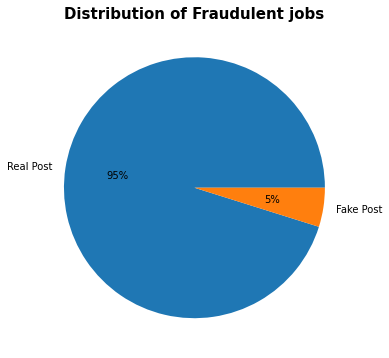

In [33]:
sql_statement_fra = """
select count(p.job_id) as JobPostings,fraudulent from posting p group by fraudulent
"""
df_fr = pd.read_sql_query(sql_statement_fra,conn1)
plt.figure(figsize=(10,6))
plt.title('Distribution of Fraudulent jobs',size=15, weight='bold')
plt.pie(df_fr['JobPostings'], labels = ['Real Post', 'Fake Post'], autopct='%1.0f%%');
plt.show()

plt.show()


###### - In overall data, there are 95.15% real jobs and 4.84% fraudulent jobs

<h2 style = "color : Blue"> Distribution of data with respect to location </h2>

In [38]:
sql_statement_eda_loc1 = """
select
CASE l.Country
        WHEN '' THEN 'Unknown'
        ELSE l.Country
    END Country,
count(p.job_id) as jobs
from posting p inner join location l
on l.LocationID = p.LocationID
where p.fraudulent = 1
group by
CASE l.Country
        WHEN '' THEN 'Unknown'
        ELSE l.Country
    END
order by jobs desc
limit 20
"""
df_count_1 = pd.read_sql_query(sql_statement_eda_loc1,conn1)

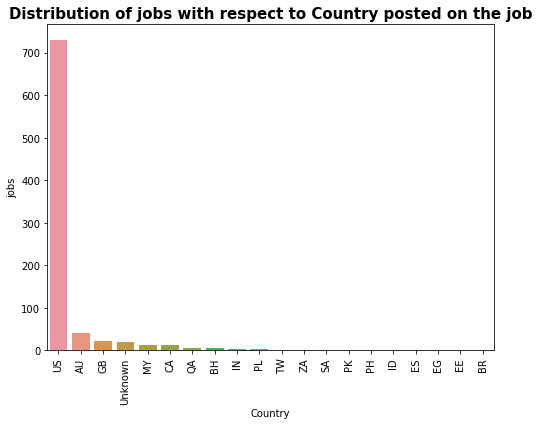

In [40]:
plt.figure(figsize=(8,6))
chart = sns.barplot(data=df_count_1, x=df_count_1.Country, y=df_count_1.jobs)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.title('Distribution of jobs with respect to Country posted on the job',size=15, weight='bold')
plt.show()

###### - Jobs posted in US have the most fraudulent jobs

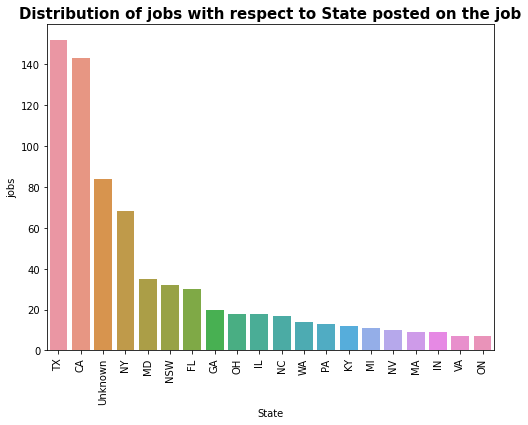

In [41]:
sql_statement_eda_loc1 = """
select
CASE l.State
        WHEN '' THEN 'Unknown'
        ELSE l.State
    END State,
count(p.job_id) as jobs
from posting p inner join location l
on l.LocationID = p.LocationID
where p.fraudulent = 1
group by
State
order by jobs desc
limit 20
"""
df_state_1 = pd.read_sql_query(sql_statement_eda_loc1,conn1)

plt.figure(figsize=(8,6))
chart = sns.barplot(data=df_state_1, x=df_state_1.State, y=df_state_1.jobs)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.title('Distribution of jobs with respect to State posted on the job',size=15, weight='bold')
plt.show()


###### - Out of jobs posted in all the states texas has the most fraudulent jobs

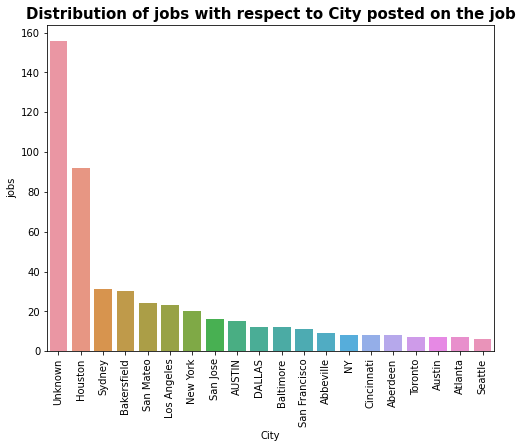

In [42]:
sql_statement_eda_loc1 = """
select
CASE l.City
        WHEN '' THEN 'Unknown'
        ELSE l.City
    END City,
count(p.job_id) as jobs
from posting p inner join location l
on l.LocationID = p.LocationID
where p.fraudulent = 1
group by
City
order by jobs desc
limit 20
"""
df_city_1 = pd.read_sql_query(sql_statement_eda_loc1,conn1)

plt.figure(figsize=(8,6))
chart = sns.barplot(data=df_city_1, x=df_city_1.City, y=df_city_1.jobs)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.title('Distribution of jobs with respect to City posted on the job',size=15, weight='bold')
plt.show()


###### - Out of jobs posted in all the cities, other than unknown, Houston has the most fraudulent jobs

<h2 style = "color : Blue"> Distribution of data with respect to departments </h2>

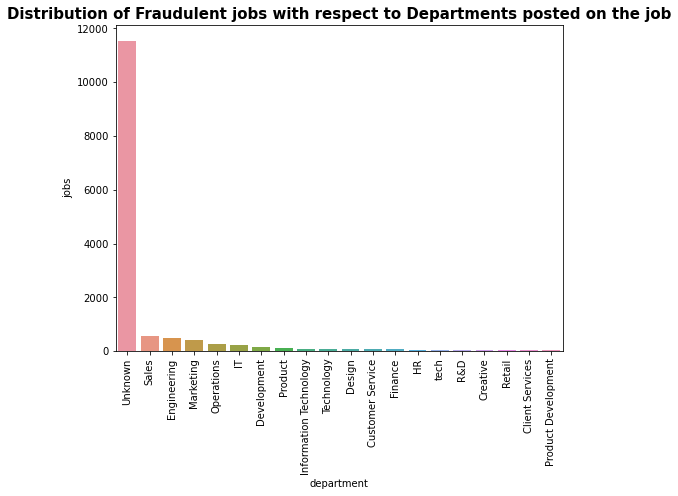

In [43]:
sql_statement_eda_dept = """
select
CASE d.department
        WHEN '' THEN 'Unknown'
        ELSE d.department
    END department,
count(p.job_id) as jobs
from posting p inner join departments d
on d.DepartmentID = p.DepartmentID
group by
CASE d.department
        WHEN '' THEN 'Unknown'
        ELSE d.department
    END
order by jobs desc
limit 20
"""


df_dept = pd.read_sql_query(sql_statement_eda_dept,conn1)
df_dept
plt.figure(figsize=(8,6))
chart = sns.barplot(data=df_dept, x=df_dept.department, y=df_dept.jobs)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.title('Distribution of Fraudulent jobs with respect to Departments posted on the job',size=15, weight='bold')
plt.show()


###### - Department column have very high null values hence it has to be dropped before creating the model

<h2 style = "color : Blue"> Distribution of data with respect to Salary Range</h2>

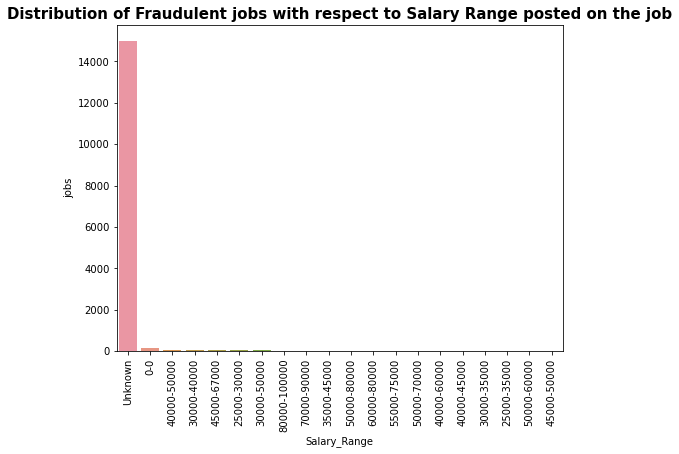

In [44]:
sql_statement_eda_sal = """
select
CASE s.Salary_Range
        WHEN '' THEN 'Unknown'
        ELSE s.Salary_Range
    END Salary_Range,
count(p.job_id) as jobs
from posting p inner join Salaries s
on s.SalaryID = p.SalaryID
group by
CASE s.Salary_Range
        WHEN '' THEN 'Unknown'
        ELSE s.Salary_Range
    END
order by jobs desc
limit 20
"""


df_sal = pd.read_sql_query(sql_statement_eda_sal,conn1)

plt.figure(figsize=(8,6))
chart = sns.barplot(data=df_sal, x=df_sal.Salary_Range, y=df_sal.jobs)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.title('Distribution of Fraudulent jobs with respect to Salary Range posted on the job',size=15, weight='bold')
plt.show()


###### - Salary Range column have very high null values hence it has to be dropped before creating the model

<h2 style = "color : Blue"> Distribution of fraudulent jobs with respect to Employee type</h2>

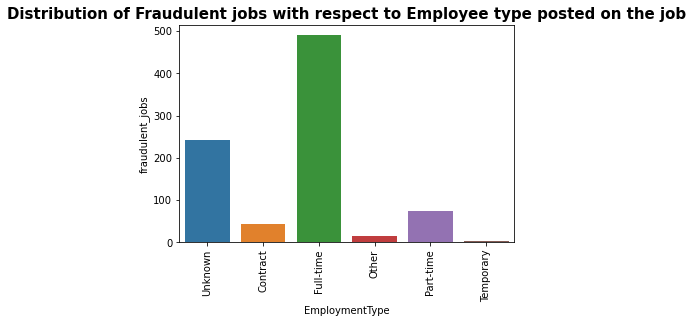

In [45]:
sql_statement_eda = """
select
CASE e.EmploymentType
        WHEN '' THEN 'Unknown'
        ELSE e.EmploymentType
    END EmploymentType,
    count(p.job_id) as fraudulent_jobs from EmploymentTypes e
inner join Posting p
on e.EmploymentTypeId = p.EmploymentTypeId
where p.fraudulent = 1
group by EmploymentType
"""
df = pd.read_sql_query(sql_statement_eda,conn1)
sns.barplot(x = df.EmploymentType, y = df.fraudulent_jobs)
plt.xticks(rotation = 90)
plt.title('Distribution of Fraudulent jobs with respect to Employee type posted on the job',size=15, weight='bold')
plt.show()

###### - Jobs with full time post have the most number of fraudulent jobs

<h2 style = "color : Blue"> Distribution of fraudulent jobs with respect to Company Logo</h2>

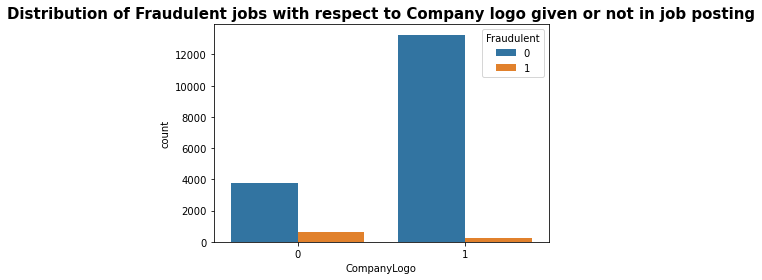

In [46]:
sql_statement_que = """
select p.job_id as JobPostings,c.has_company_logo as CompanyLogo,p.fraudulent as Fraudulent from posting p
inner join Company c on c.companyID = p.companyID
"""

df_comp = pd.read_sql_query(sql_statement_que,conn1)
sns.countplot( x=df_comp.CompanyLogo,hue=df_comp.Fraudulent)

plt.title('Distribution of Fraudulent jobs with respect to Company logo given or not in job posting',size=15, weight='bold')
plt.show()

###### - Jobs with no company logo have more fradulent jobs than with company logo

<h2 style = "color : Blue"> Distribution of fraudulent jobs with respect to Telecommuting</h2>

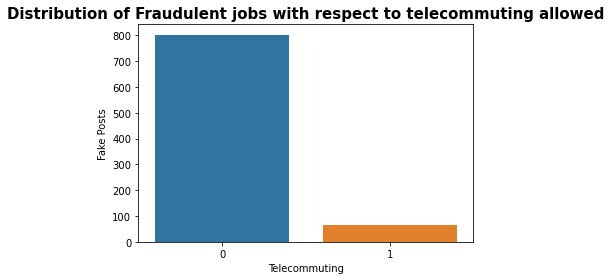

In [47]:
sql_statement_tel = """
select count(p.job_id) as JobPostings,telecommuting,p.fraudulent as Fraudulent from posting p
where p.fraudulent = 1
group by telecommuting,p.fraudulent
"""
df_tel = pd.read_sql_query(sql_statement_tel,conn1)
sns.barplot(x = df_tel['telecommuting'], y = df_tel['JobPostings'])
plt.title('Distribution of Fraudulent jobs with respect to telecommuting allowed',size=15, weight='bold')
plt.xlabel("Telecommuting")
plt.ylabel("Fake Posts")
plt.show()

###### - It was assumed that jobs which allow telecommuting will have more chances of being fake but contrary to the assumption fake jobs are more when telecommuting is not allowed

<h2 style = "color : Blue"> Distribution of fraudulent jobs with respect to has_questions</h2>

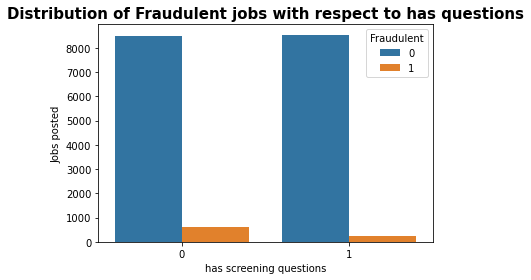

In [48]:
sql_statement_ques = """
select p.job_id as JobPostings,has_questions as Questions,p.fraudulent as Fraudulent from posting p
"""
df_ques = pd.read_sql_query(sql_statement_ques,conn1)
sns.countplot(data = df_ques, x='Questions',hue='Fraudulent')
plt.title('Distribution of Fraudulent jobs with respect to has questions',size=15, weight='bold')
plt.xlabel("has screening questions")
plt.ylabel("Jobs posted")
plt.show()


###### - Job postings which doesn't have screening questions are tend to be fake more than the ones which have

<h2 style = "color : Blue"> Distribution of fraudulent jobs with respect to number of words in company profile</h2>

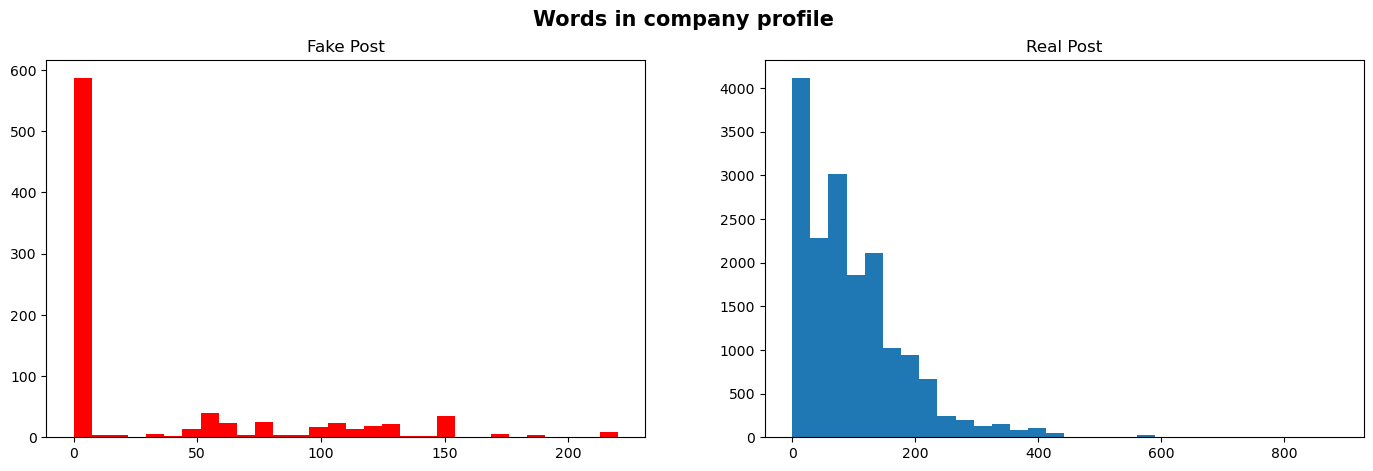

In [49]:
def count_words(value):
    value2 = value.str.split()
    return value2.map(lambda x: len(x))

sql_statement_words = """
select c.company_profile from posting p
inner join company c on c.CompanyID = p.CompanyID where p.fraudulent=1
"""
df_words = pd.read_sql_query(sql_statement_words,conn1)

fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
num = count_words(df_words['company_profile'])
ax1.hist(num,bins = 30,color='Red')
ax1.set_title('Fake Post')

sql_statement_words = """
select c.company_profile from posting p
inner join company c on c.CompanyID = p.CompanyID where p.fraudulent=0
"""
df_words = pd.read_sql_query(sql_statement_words,conn1)

num_real_words = count_words(df_words['company_profile'])
ax2.hist(num_real_words, bins = 30)
ax2.set_title('Real Post')
fig.suptitle('Words in company profile',size=15, weight='bold')
plt.show()


###### - Company profile in Real posts have more number of words than fake posts

<h2 style = "color : Blue"> Distribution of fake post with respect to Industry</h2>

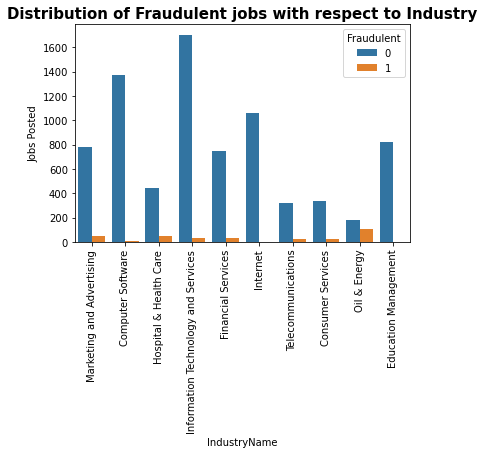

In [50]:

sql_statement_ind = """
with table1 as (select i.IndustryId,i.IndustryName as IndustryName,count(p.job_id) as JobPostings from posting p
 inner join Industry i on i.IndustryId = p.IndustryId where IndustryName != ''
 group by IndustryName order by JobPostings desc limit 10)
 select t.IndustryName,p.fraudulent as Fraudulent,p.job_id as JobPostings from posting p
 inner join table1 t on t.IndustryId = p.IndustryId

"""


df_ind = pd.read_sql_query(sql_statement_ind,conn1)
df_ind
sns.countplot(data = df_ind, x='IndustryName',hue='Fraudulent')
plt.title('Distribution of Fraudulent jobs with respect to Industry',size=15, weight='bold')
plt.xlabel("IndustryName")
plt.ylabel("Jobs Posted")
plt.xticks(rotation = 90)
plt.show()


###### - Oil and Energy have the highest fake job posts

<h2 style = "color : Blue">Distribution of fake post with respect to Industry for US Country</h2>

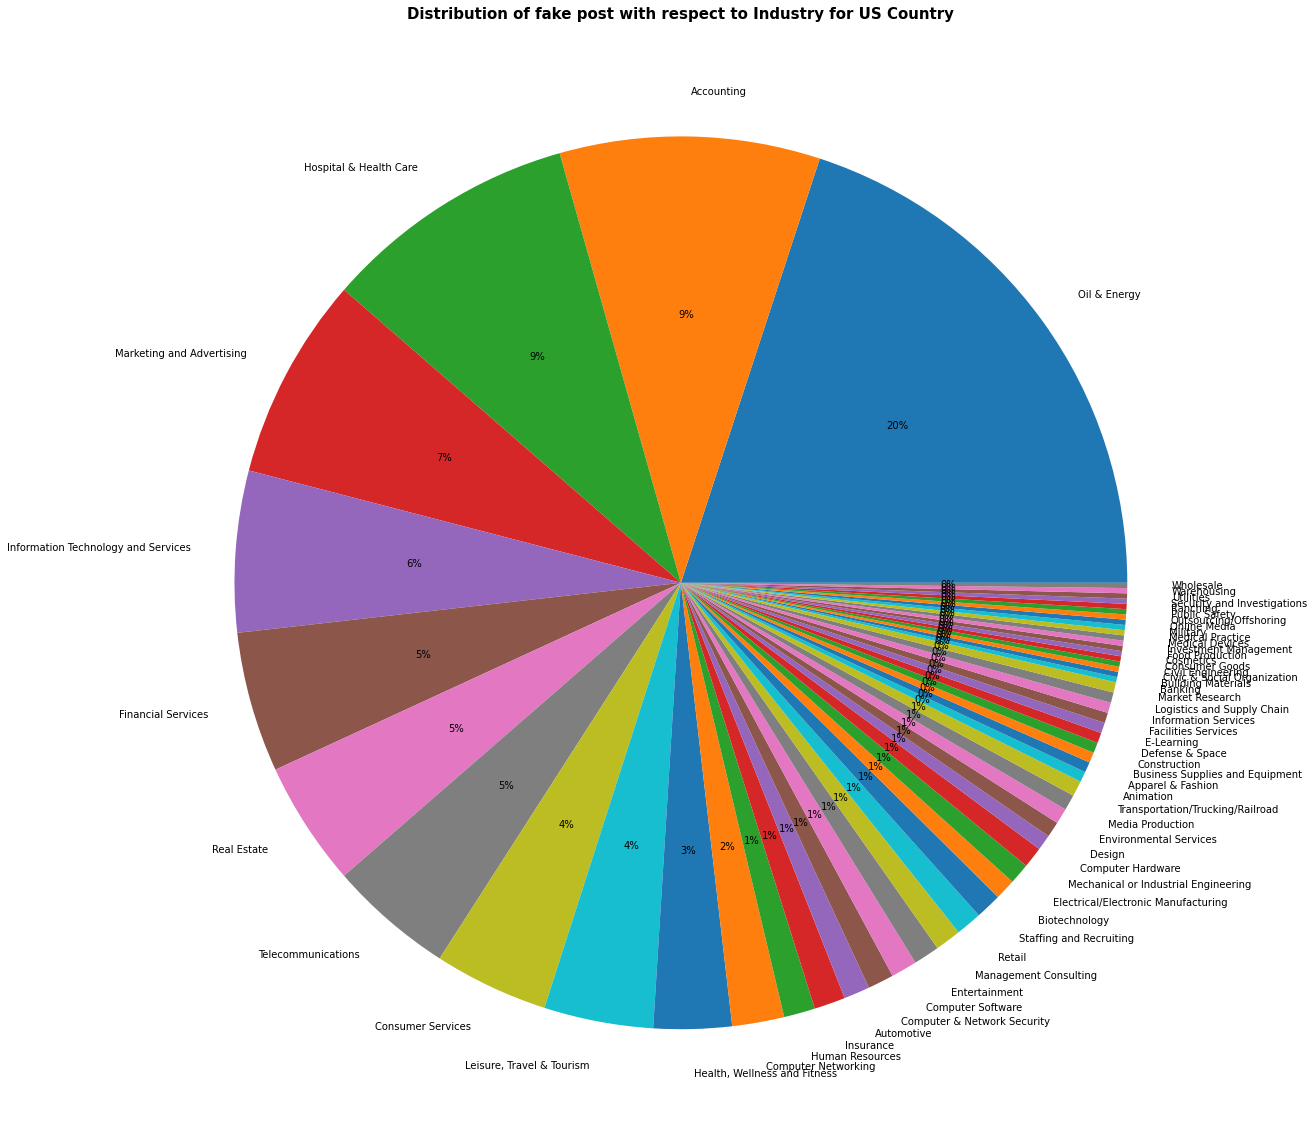

In [76]:
sql_statement_bivariate = """
WITH table1 as (
SELECT loc.Country, COUNT(post.fraudulent) as total_fraud_postings
FROM Posting post INNER JOIN Location loc ON post.LocationID = loc.LocationID
INNER JOIN Industry ind ON post.IndustryId = ind.IndustryId
WHERE post.fraudulent = 1 AND ind.IndustryName != '' AND loc.Country != ''
GROUP BY loc.Country
)
SELECT loc.Country, ind.IndustryName, Count(post.fraudulent) as fraud_postings, table1.total_fraud_postings
FROM Posting post INNER JOIN Location loc ON post.LocationID = loc.LocationID
INNER JOIN Industry ind ON post.IndustryId = ind.IndustryId
INNER JOIN table1 ON table1.Country = loc.Country
WHERE post.fraudulent = 1 AND ind.IndustryName != '' and loc.Country = 'US'
GROUP BY loc.Country, ind.IndustryName
ORDER BY loc.Country, -fraud_postings
"""

df_ind = pd.read_sql_query(sql_statement_bivariate,conn1)
df_ind
df_ind['percentages'] = df_ind['fraud_postings']/df_ind['total_fraud_postings']

plt.figure(figsize=(20,30))
plt.pie(df_ind['percentages'], labels = df_ind['IndustryName'], autopct='%1.0f%%');
plt.title('Distribution of fake post with respect to Industry for US Country',size=15, weight='bold')
plt.show()

<h2 style = "color : Blue"> Distribution of fake post with respect to Function</h2>

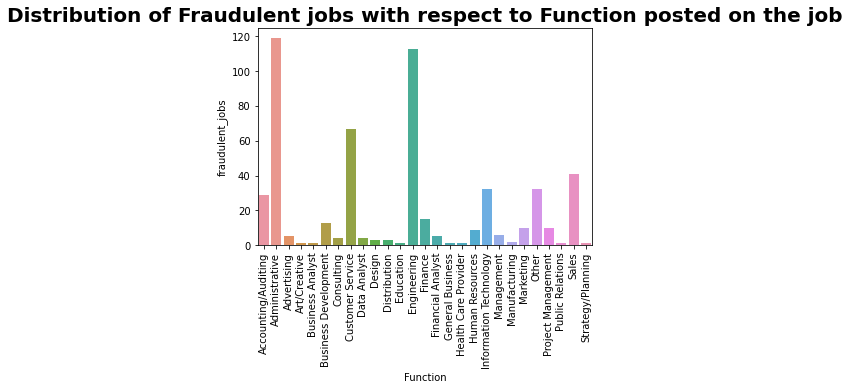

In [52]:
sql_statement_func = """
select f.function as Function,count(p.job_id) as fraudulent_jobs from posting p
inner join function f on f.functionID = p.functionID where function != '' and Fraudulent = 1
group by Function
"""

df_func = pd.read_sql_query(sql_statement_func,conn1)
sns.barplot(x = df_func.Function, y = df_func.fraudulent_jobs)
plt.xticks(rotation = 90)
plt.title('Distribution of Fraudulent jobs with respect to Function posted on the job',size=20, weight='bold')
plt.show()


###### - Administrative and Engineering function jobs have more fake job post

<h2 style = "color : Blue"> Distribution of fake post with respect to Required Education</h2>

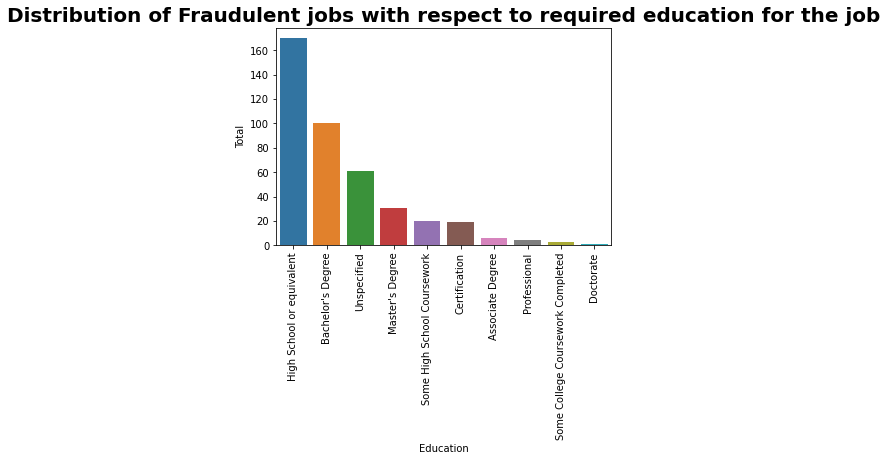

In [53]:

sql_statement_eda_edu = """
select
e.Education,
    count(p.job_id) as Total 
from Posting p inner join RequiredEducation e using (RequiredEducationId)
where p.fraudulent = 1 and e.Education !=''
group by e.Education
order by Total DESC
"""
df_edu = pd.read_sql_query(sql_statement_eda_edu,conn1)
sns.barplot(x = df_edu.Education, y = df_edu.Total)
plt.xticks(rotation = 90)
plt.title('Distribution of Fraudulent jobs with respect to required education for the job',size=20, weight='bold')
plt.show()



###### - As compared to other required education, High School or equivalent job posts are more fake

<h2 style = "color : Blue"> Distribution of fake post with respect to Required Experience</h2>

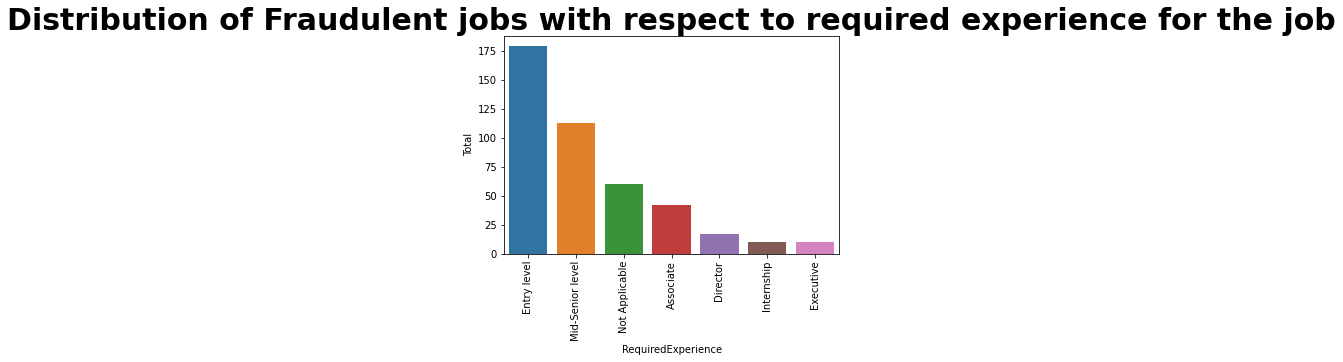

In [54]:
sql_statement_eda_exp = """
select
r.RequiredExperience,
        
    count(p.job_id) as Total from RequiredExperiences r
inner join Posting p
on r.RequiredExperienceId = p.RequiredExperienceId
where p.fraudulent = 1 and r.RequiredExperience != ''
group by r.RequiredExperience
order by Total DESC
"""

df_exp = pd.read_sql_query(sql_statement_eda_exp,conn1)
sns.barplot(x = df_exp.RequiredExperience, y = df_exp.Total)
plt.xticks(rotation = 90)
plt.title('Distribution of Fraudulent jobs with respect to required experience for the job',size=30, weight='bold')
plt.show()



###### - As compared to other required experience, Entry level job posts are more fake

In [55]:
sql_statement_ex = """
select 
    RequiredExperience as Experience,
    Education as Education,
    count(p.job_id) as JOB 
from Posting p left join RequiredExperiences using (RequiredExperienceId) left join RequiredEducation using (RequiredEducationId)
where p.fraudulent = 1 and RequiredExperience = 'Entry level' and Education!=''
group by RequiredExperience, Education
order by JOB DESC
"""
dfexper = pd.read_sql_query(sql_statement_ex,conn1)
print(dfexper)

    Experience                          Education  JOB
0  Entry level          High School or equivalent   90
1  Entry level                        Unspecified   21
2  Entry level        Some High School Coursework   20
3  Entry level                  Bachelor's Degree   10
4  Entry level                      Certification    5
5  Entry level                    Master's Degree    3
6  Entry level                   Associate Degree    2
7  Entry level  Some College Coursework Completed    2


<h2 style = "color : Blue">Word Cloud for Title</h2>

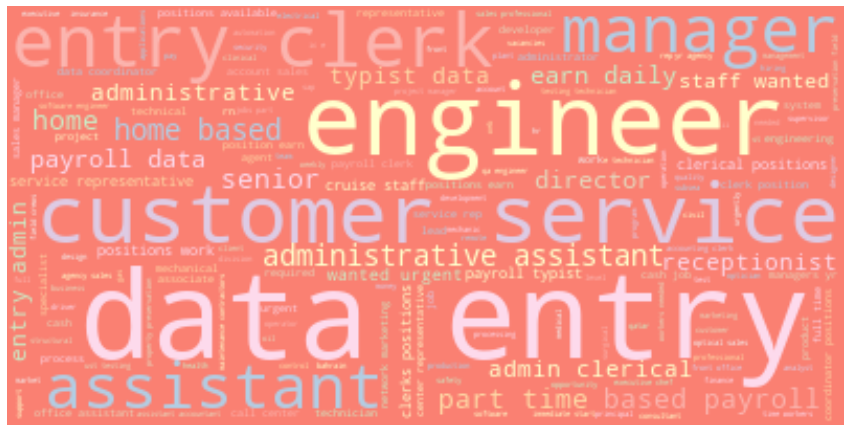

In [56]:
sql_statement_eda_title = """
select p.job_id,
t.title
from titles t inner join posting p
on t.titleID = p.titleid
where p.fraudulent = 1
"""


df_title = pd.read_sql_query(sql_statement_eda_title,conn1)

text = df_title.Title
text = ' '.join(text).lower()
text


wordcloud = WordCloud(stopwords = STOPWORDS,background_color = "salmon",
                      colormap="Pastel1",
                      collocations=True).generate(text)

plt.figure(figsize=(15,10))

plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()



###### - In all the fake jobs title, the most used word is data entry

In [57]:
text_dictionary = wordcloud.process_text(text)
word_freq={k: v for k, v in sorted(text_dictionary.items(),reverse=True, key=lambda item: item[1])}
print(list(word_freq.items())[:10])

[('data entry', 103), ('engineer', 68), ('customer service', 56), ('entry clerk', 48), ('manager', 41), ('assistant', 37), ('administrative assistant', 36), ('home based', 36), ('home', 33), ('based payroll', 33)]


In [58]:
sql_statement_ex = """
select 
    e.Education as Education,
    count(p.job_id) as JOB 
from Posting p inner join titles t on t.titleid = p.titleid
inner join RequiredEducation e on e.RequiredEducationId = p.RequiredEducationId
where p.fraudulent = 1 and t.Title like "%data entry%" and e.Education!=''
group by Education
order by JOB DESC
"""
dfexper = pd.read_sql_query(sql_statement_ex,conn1)
print(dfexper)

                     Education  JOB
0    High School or equivalent   14
1                  Unspecified   12
2  Some High School Coursework    7
3            Bachelor's Degree    2
4              Master's Degree    1


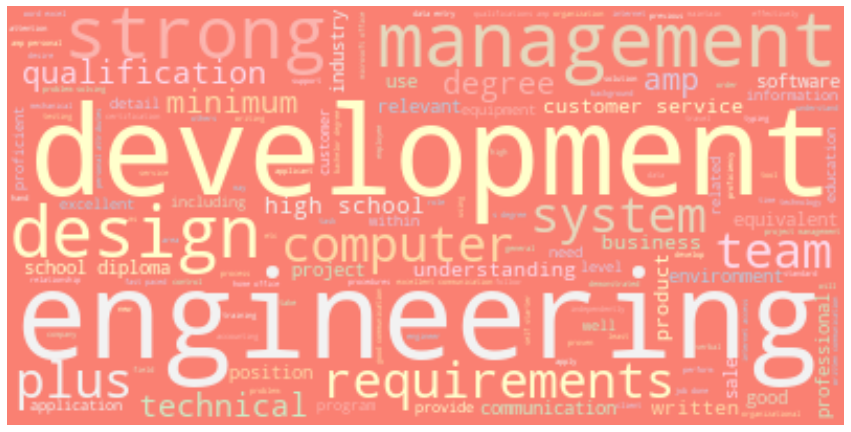

In [59]:
sql_statement_eda_req = """
select p.job_id,
r.requirement
from posting p
inner join requirements r
on p.requirementid = r.requirementid
where p.fraudulent = 1
"""


df_req = pd.read_sql_query(sql_statement_eda_req,conn1)
text = df_req.Requirement
text = ' '.join(text).lower()

STOPWORDS.update(["experience","requirement","required","knowledge",
                  "ability","work","must","year","able","skill","years","skills",
                 "working","preferred"])


wordcloud = WordCloud(stopwords = STOPWORDS,background_color = "salmon",
                      colormap="Pastel1",
                      collocations=True).generate(text)

plt.figure(figsize=(15,10))

plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()



In [60]:
text_dictionary = wordcloud.process_text(text)
word_freq={k: v for k, v in sorted(text_dictionary.items(),reverse=True, key=lambda item: item[1])}
print(list(word_freq.items())[:10])

[('development', 114), ('engineering', 111), ('management', 110), ('strong', 107), ('design', 107), ('requirements', 106), ('team', 104), ('computer', 103), ('plus', 103), ('system', 101)]


###### - In all the fake jobs requirements, the most used word is development and engineering

## Modelling

#### We have selected the columns, Country, has_company_logo, telecommuting, has_questions, EmploymentTypeId, RequiredExperienceId, RequiredEducationId, IndustryId, functionID, fraudulent and did not consider the columns which have high null values and which are not relevant to the analysis, i.e. Unique IDs

In [61]:
sql_statement_modelling = """
                        SELECT loc.Country,
                            comp.has_company_logo,
                            post.telecommuting,
                            post.has_questions,
                            post.EmploymentTypeId,
                            post.RequiredExperienceId,
                            post.RequiredEducationId,
                            post.IndustryId,
                            post.functionID,
                            post.fraudulent
                            
                        FROM Posting post INNER JOIN Company comp ON post.CompanyID = comp.CompanyID
                                        INNER JOIN Location loc ON post.LocationID = loc.LocationID
                            """

In [62]:
conn = create_connection("normalized_data.db")
with conn:
    df = pd.read_sql_query(sql_statement_modelling, conn)

#### If unique values are more than 2 then it is converted to category type so that pandas can convert it into dummy variables

In [63]:
for col in df.columns:
    if df[col].nunique() > 2:
        df[col] = df[col].astype('category')

#### Creating Dummy Variables

In [64]:
df = pd.get_dummies(df)

In [65]:
df

,has_company_logo,telecommuting,has_questions,fraudulent,Country_,Country_AE,Country_AL,Country_AM,Country_AR,Country_AT,...,functionID_29,functionID_30,functionID_31,functionID_32,functionID_33,functionID_34,functionID_35,functionID_36,functionID_37,functionID_38
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17876,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17877,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17878,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Splitting the data into X and Y for dependent and independent variables

In [66]:
X = df.drop('fraudulent', axis=1)
Y = df['fraudulent']

In [67]:
Y.value_counts()

0    17014
1      866
Name: fraudulent, dtype: int64

#### Splitting X and Y into test and train for modelling

In [68]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, stratify=Y)

#### Using RandomForestClassifier() function from sklearn to create a Random Forest model

In [69]:
forest_model = RandomForestClassifier()
forest_model.fit(x_train, y_train)

RandomForestClassifier()

#### Using test data from X to predict independent values from the model

In [70]:
y_pred = forest_model.predict(x_test)

#### Displaying Classification metrics

In [71]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4253
           1       0.88      0.51      0.64       217

    accuracy                           0.97      4470
   macro avg       0.93      0.75      0.81      4470
weighted avg       0.97      0.97      0.97      4470



In [72]:
conf_mat = confusion_matrix(y_test, y_pred)

In [73]:
disp = ConfusionMatrixDisplay(conf_mat)

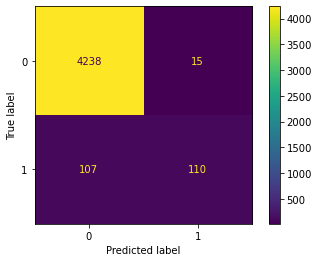

In [74]:
disp.plot()
plt.show()